<a href="https://colab.research.google.com/github/aznedac2/CS231N_17_KOR_SUB/blob/master/vol_coin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance arch statsmodels seaborn aiohttp pysabr

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time

def fetch_deribit_candles(instrument_name='BTC-PERPETUAL', resolution='1', start_timestamp=None, end_timestamp=None):
    """
    Deribit API에서 캔들 데이터 가져오기
    resolution: '1' for 1-minute, '5' for 5-minute, etc.
    """
    url = "https://www.deribit.com/api/v2/public/get_tradingview_chart_data"

    params = {
        "instrument_name": instrument_name,
        "resolution": resolution,
        "start_timestamp": start_timestamp,
        "end_timestamp": end_timestamp,
    }

    resp = requests.get(url, params=params)
    data = resp.json()

    if 'result' not in data:
        print("Error:", data)
        return None

    df = pd.DataFrame(data['result'])
    df['timestamp'] = pd.to_datetime(df['ticks'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df = df[['open', 'high', 'low', 'close', 'volume']]
    return df

def get_daily_ohlc(start_date, end_date):
    """
    지정된 기간 동안 일별 OHLC 데이터 리턴
    """
    all_data = []
    current_date = start_date
    while current_date <= end_date:
        start_ts = int(current_date.timestamp() * 1000)
        end_ts = int((current_date + timedelta(days=1)).timestamp() * 1000)

        print(f"Fetching data for: {current_date.date()}")
        df = fetch_deribit_candles(start_timestamp=start_ts, end_timestamp=end_ts)

        if df is not None and not df.empty:
            # 일별 OHLC로 리샘플링
            daily = df.resample('1D').agg({
                'open': 'first',
                'high': 'max',
                'low': 'min',
                'close': 'last',
                'volume': 'sum'
            })
            all_data.append(daily)

        time.sleep(0.3)  # API 요청 제한 회피
        current_date += timedelta(days=1)

    final_df = pd.concat(all_data)
    return final_df

In [ ]:
# 사용 예시
start_date = datetime(2025, 1, 1)
end_date = datetime(2025, 4, 5)
df_daily = get_daily_ohlc(start_date, end_date)
print(df_daily)

Fetching data for: 2025-01-01
Fetching data for: 2025-01-02
Fetching data for: 2025-01-03
Fetching data for: 2025-01-04
Fetching data for: 2025-01-05
Fetching data for: 2025-01-06
Fetching data for: 2025-01-07
Fetching data for: 2025-01-08
Fetching data for: 2025-01-09
Fetching data for: 2025-01-10
Fetching data for: 2025-01-11
Fetching data for: 2025-01-12
Fetching data for: 2025-01-13
Fetching data for: 2025-01-14
Fetching data for: 2025-01-15
Fetching data for: 2025-01-16
Fetching data for: 2025-01-17
Fetching data for: 2025-01-18
Fetching data for: 2025-01-19
Fetching data for: 2025-01-20
Fetching data for: 2025-01-21
Fetching data for: 2025-01-22
Fetching data for: 2025-01-23
Fetching data for: 2025-01-24
Fetching data for: 2025-01-25
Fetching data for: 2025-01-26
Fetching data for: 2025-01-27
Fetching data for: 2025-01-28
Fetching data for: 2025-01-29
Fetching data for: 2025-01-30
Fetching data for: 2025-01-31
Fetching data for: 2025-02-01
Fetching data for: 2025-02-02
Fetching d

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import het_arch
from scipy.stats import skew, kurtosis, normaltest

# 1. 데이터 수집 (BTCUSDT)
btc = yf.download("BTC-USD", start="2015-01-01", end="2025-04-01")
btc.columns = btc.columns.levels[0]
btc["log_ret"] = np.log(btc["Close"] / btc["Close"].shift(1))
returns = btc["log_ret"].dropna()


[*********************100%***********************]  1 of 1 completed


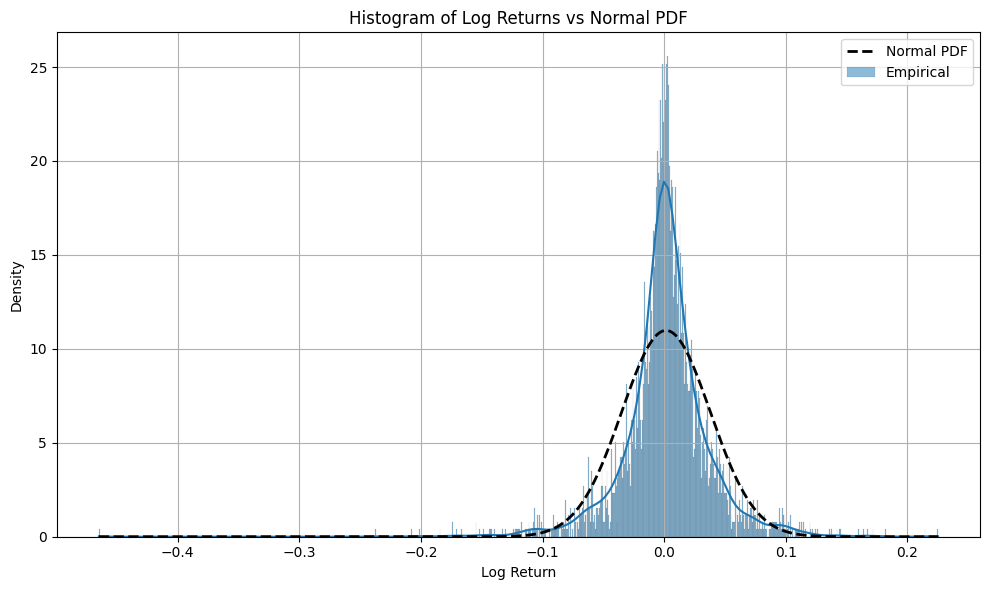

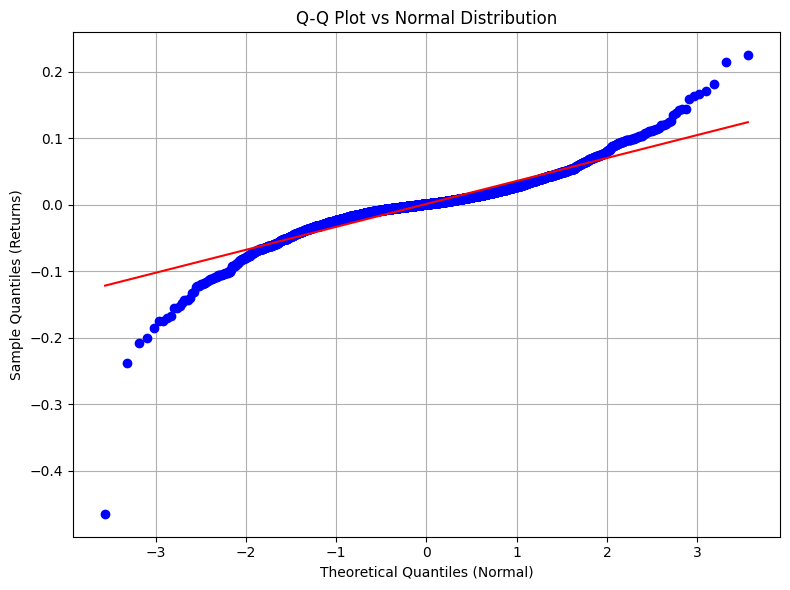

Normality Test p-value: 0.0000
p-value가 0.05 이하면 정규분포로 보기 어려우므로 constant vol 모델 사용 어려움


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
from scipy.stats import norm

# 히스토그램 + 정규분포 PDF 비교 시각화
plt.figure(figsize=(10, 6))
sns.histplot(returns, bins=1000, kde=True, stat="density", label="Empirical")

# 정규분포 PDF 계산
x = np.linspace(returns.min(), returns.max(), 1000)
pdf = norm.pdf(x, returns.mean(), returns.std())
plt.plot(x, pdf, color='black', linestyle='--', linewidth=2, label="Normal PDF")

# 그래프 설정
# plt.xlim(-0.2, -0.1)
plt.title("Histogram of Log Returns vs Normal PDF")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Q-Q 플롯 (정규분포와 비교)
plt.figure(figsize=(8, 6))
probplot(returns, dist="norm", plot=plt)
plt.title("Q-Q Plot vs Normal Distribution")
plt.xlabel("Theoretical Quantiles (Normal)")
plt.ylabel("Sample Quantiles (Returns)")
plt.grid(True)
plt.tight_layout()
plt.show()


# 2. 분포 분석
stat, p = normaltest(returns)
print(f"Normality Test p-value: {p:.4f}")
print('p-value가 0.05 이하면 정규분포로 보기 어려우므로 constant vol 모델 사용 어려움')


In [ ]:
print(f"Skewness: {skew(returns):.3f}")
print(f"Kurtosis: {kurtosis(returns, fisher=True):.3f}")

print('Skewness가 0에서 벗어나있으므로 왜도 있고, Kurtosis가 3 이상이라 Fat-tail로 볼 수 있음')

Skewness: -0.744
Kurtosis: 11.557
Skewness가 0에서 벗어나있으므로 왜도 있고, Kurtosis가 3 이상이라 Fat-tail로 볼 수 있음


In [ ]:
# 3. ARCH 효과 테스트
arch_stat, arch_pvalue, _, _ = het_arch(returns)
print(f"ARCH test p-value: {arch_pvalue:.4f}")

# 4. GARCH(1,1) 적합
model = arch_model(returns, vol='Garch', p=1, q=1)
res = model.fit(disp="off")
print(res.summary())


ARCH test p-value: 0.0000
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                log_ret   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2582.65
Distribution:                  Normal   AIC:                          -5157.30
Method:            Maximum Likelihood   BIC:                          -5136.99
                                        No. Observations:                 1185
Date:                Mon, Apr 21 2025   Df Residuals:                     1184
Time:                        04:22:47   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.1810e-03  7.340e

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0008035. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


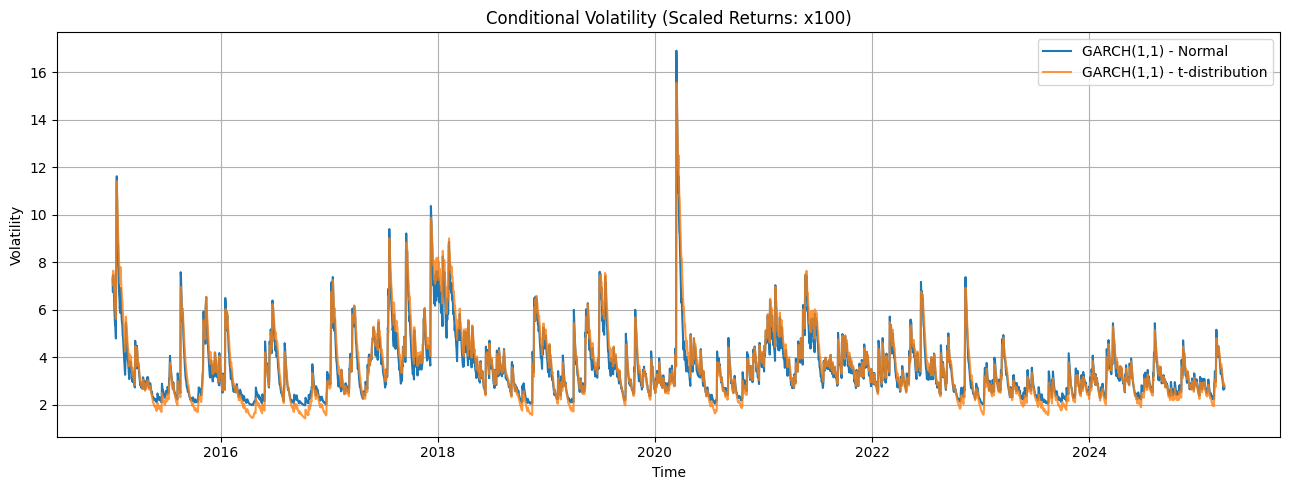

AIC (Normal): 19610.99
AIC (t-dist): 18645.75
Estimated nu (t-dist degrees of freedom): 3.16


In [ ]:
# 📌 GARCH 최적화 안정성을 위해 스케일 조정
returns_scaled = returns * 100

# GARCH(1,1) - Normal
model_normal = arch_model(returns_scaled, vol='GARCH', p=1, q=1, dist='normal')
res_normal = model_normal.fit(disp='off')

# GARCH(1,1) - t-distribution
model_t = arch_model(returns_scaled, vol='GARCH', p=1, q=1, dist='t')
res_t = model_t.fit(disp='off')

# 조건부 변동성
vol_normal = res_normal.conditional_volatility
vol_t = res_t.conditional_volatility

# 시각화
plt.figure(figsize=(13, 5))
plt.plot(vol_normal, label='GARCH(1,1) - Normal')
plt.plot(vol_t, label='GARCH(1,1) - t-distribution', alpha=0.8)
plt.title("Conditional Volatility (Scaled Returns: x100)")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 성능 지표 출력
print(f"AIC (Normal): {res_normal.aic:.2f}")
print(f"AIC (t-dist): {res_t.aic:.2f}")
print(f"Estimated nu (t-dist degrees of freedom): {res_t.params['nu']:.2f}")

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Skewness: 0.0867
Kurtosis: 22.2356
Normality test p-value: 0.0000


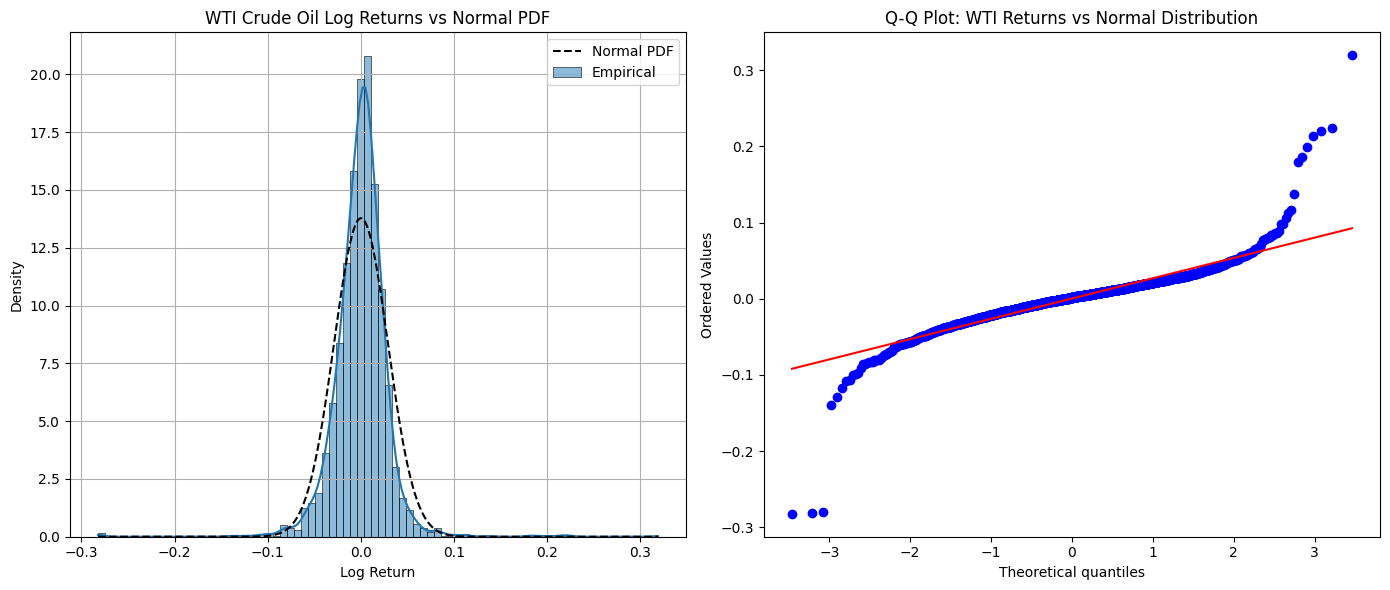

In [ ]:
# 1. WTI 원유 선물 데이터 다운로드 (CL=F)
wti = yf.download("CL=F", start="2015-01-01", end="2025-04-01")
wti.columns = wti.columns.levels[0]
wti["log_ret"] = np.log(wti["Close"] / wti["Close"].shift(1))
returns = wti["log_ret"].dropna()

# 2. 통계량 계산
print(f"Skewness: {skew(returns):.4f}")
print(f"Kurtosis: {kurtosis(returns, fisher=True):.4f}")
print(f"Normality test p-value: {normaltest(returns).pvalue:.4f}")

# 3. 시각화: 히스토그램 + 정규분포 PDF
plt.figure(figsize=(14, 6))

# 히스토그램 + 정규 PDF
plt.subplot(1, 2, 1)
sns.histplot(returns, bins=80, kde=True, stat="density", label="Empirical")
x = np.linspace(returns.min(), returns.max(), 1000)
pdf = norm.pdf(x, returns.mean(), returns.std())
plt.plot(x, pdf, 'k--', label='Normal PDF')
plt.title("WTI Crude Oil Log Returns vs Normal PDF")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)

# Q-Q 플롯
plt.subplot(1, 2, 2)
probplot(returns, dist="norm", plot=plt)
plt.title("Q-Q Plot: WTI Returns vs Normal Distribution")

plt.tight_layout()
plt.show()


In [81]:
import requests

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import norm
from scipy.optimize import brentq

from datetime import datetime

# Black-Scholes 가격 계산 함수
def bs_price(option_type, S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    if option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

# Implied Volatility 계산 함수
def implied_vol(price, option_type, S, K, T, r):
    try:
        return brentq(lambda sigma: bs_price(option_type, S, K, T, r, sigma) - price * S, 1e-5, 5)
    except:
        return np.nan

# Deribit에서 옵션 리스트 가져오기
def get_option_instruments(currency="BTC", kind="option", expired=False):
    url = "https://www.deribit.com/api/v2/public/get_instruments"
    params = {
        "currency": currency,
        "kind": kind,
        "expired": str(expired).lower()  # API는 'true' or 'false' string을 요구함
    }

    response = requests.get(url, params=params)
    data = response.json()

    if 'error' in data:
        print(f"API Error: {data['error']['message']}")
        return []

    instruments = data.get("result", [])
    return instruments

# 옵션별 IV 계산
def get_iv_for_option(inst_name, strike, expiry_timestamp, mode='mid', otm_only=True, r=0):
    url = f"https://www.deribit.com/api/v2/public/get_order_book?instrument_name={inst_name}"
    response = requests.get(url)
    data = response.json().get('result', {})

    S = data.get('underlying_price')
    K = strike
    bid = data.get('best_bid_price')
    ask = data.get('best_ask_price')
    mid = (bid + ask) / 2 if bid and ask else None

    mark_iv = data.get('mark_iv')
    bid_iv = data.get('bid_iv')
    ask_iv = data.get('ask_iv')

    if mode == 'mid':
      mid = mid
    elif mode == 'bid':
      mid = bid
    elif mode == 'ask':
      mid = ask

    T = (datetime.utcfromtimestamp(expiry_timestamp / 1000) - datetime.utcnow()).total_seconds() / (365 * 24 * 60 * 60)

    if (not mid) or (not expiry_timestamp) or (T <= 0):
        return None

    opt_type = inst_name[-1]
    # OTM : 콜옵션의 행사 가격이 기초 자산의 시장 가격보다 높을 때, 혹은 풋옵션의 행사 가격이 기초 자산의 시장 가격보다 낮을 때
    # ITM 버리기..
    if opt_type == 'C':
        opt_type = 'call'
        if otm_only is True:
            if S > K:
              return None
    elif opt_type == 'P':
        opt_type = 'put'
        if otm_only is True:
          if S < K:
            return None
    else:
        return None

    iv = implied_vol(mid, opt_type, S, K, T, r)

    expiry_date = datetime.utcfromtimestamp(expiry_timestamp / 1000).strftime('%Y-%m-%d')
    return {
        'strike': K,
        'iv': iv,
        'expiry': expiry_date,
        'mark_iv': mark_iv,
        'bid_iv': bid_iv,
        'ask_iv': ask_iv,
        'type' : opt_type
    }

# 만기별 Smile Curve 시각화
def plot_smile_curves(mode, otm_only, cutoff_str):
    options = get_option_instruments()
    iv_data = []

    cutoff_date = datetime.strptime(cutoff_str, '%Y%m%d')
    cutoff_timestamp = int(cutoff_date.timestamp() * 1000)

    for opt in options:
        inst_name = opt['instrument_name']
        strike_opt =  opt['strike']

        expiry_timestamp_opt = opt['expiration_timestamp']
        if (expiry_timestamp_opt > cutoff_timestamp):
          continue

        iv_info = get_iv_for_option(inst_name, strike_opt, expiry_timestamp_opt, mode, otm_only)

        if (iv_info and iv_info['iv'] is not None) and (iv_info['iv'] is not np.nan):
            print(inst_name, iv_info)
            # print(inst_name, iv_info['iv'])
            iv_data.append(iv_info)

    df = pd.DataFrame(iv_data)
    df = df.dropna().sort_values(['expiry', 'strike'])

    plt.figure(figsize=(12, 6))
    for expiry in sorted(df['expiry'].unique()):
        subset = df[df['expiry'] == expiry]
        plt.plot(subset['strike'], subset['iv'], marker='o', label=expiry)

    plt.title("BTC Implied Volatility Smile Curves by Expiry by " + mode)
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend(title="Expiry")
    plt.tight_layout()
    plt.show()

    df['mode'] = mode
    return df

def get_btc_futures_last_price(instrument_name="BTC-PERPETUAL"):
    """
    Deribit에서 지정한 비트코인 선물 종목의 현재가(last price)를 반환합니다.

    Parameters:
    - instrument_name: 예) 'BTC-PERPETUAL', 'BTC-27JUN25'

    Returns:
    - 현재가 (float), 실패 시 None
    """
    url = "https://www.deribit.com/api/v2/public/ticker"
    params = {"instrument_name": instrument_name}

    try:
        response = requests.get(url, params=params)
        data = response.json()
        return data["result"]["last_price"]
    except Exception as e:
        print(f"에러 발생: {e}")
        return None

BTC-23APR25-76000-P {'strike': 76000.0, 'iv': 3.9101230101917586, 'expiry': '2025-04-23', 'mark_iv': 130.97, 'bid_iv': 0.0, 'ask_iv': 390.79, 'type': 'put'}
BTC-23APR25-78000-P {'strike': 78000.0, 'iv': 3.456659053338592, 'expiry': '2025-04-23', 'mark_iv': 130.97, 'bid_iv': 0.0, 'ask_iv': 345.46, 'type': 'put'}
BTC-23APR25-80000-P {'strike': 80000.0, 'iv': 3.0100096130465928, 'expiry': '2025-04-23', 'mark_iv': 130.82, 'bid_iv': 0.0, 'ask_iv': 300.81, 'type': 'put'}
BTC-23APR25-81000-P {'strike': 81000.0, 'iv': 2.788887878715764, 'expiry': '2025-04-23', 'mark_iv': 126.92, 'bid_iv': 0.0, 'ask_iv': 278.71, 'type': 'put'}
BTC-23APR25-82000-P {'strike': 82000.0, 'iv': 2.5689540809586147, 'expiry': '2025-04-23', 'mark_iv': 115.38, 'bid_iv': 0.0, 'ask_iv': 256.72, 'type': 'put'}
BTC-23APR25-83000-P {'strike': 83000.0, 'iv': 2.350106626613999, 'expiry': '2025-04-23', 'mark_iv': 106.0, 'bid_iv': 0.0, 'ask_iv': 234.84, 'type': 'put'}
BTC-23APR25-84000-P {'strike': 84000.0, 'iv': 2.13158384140625

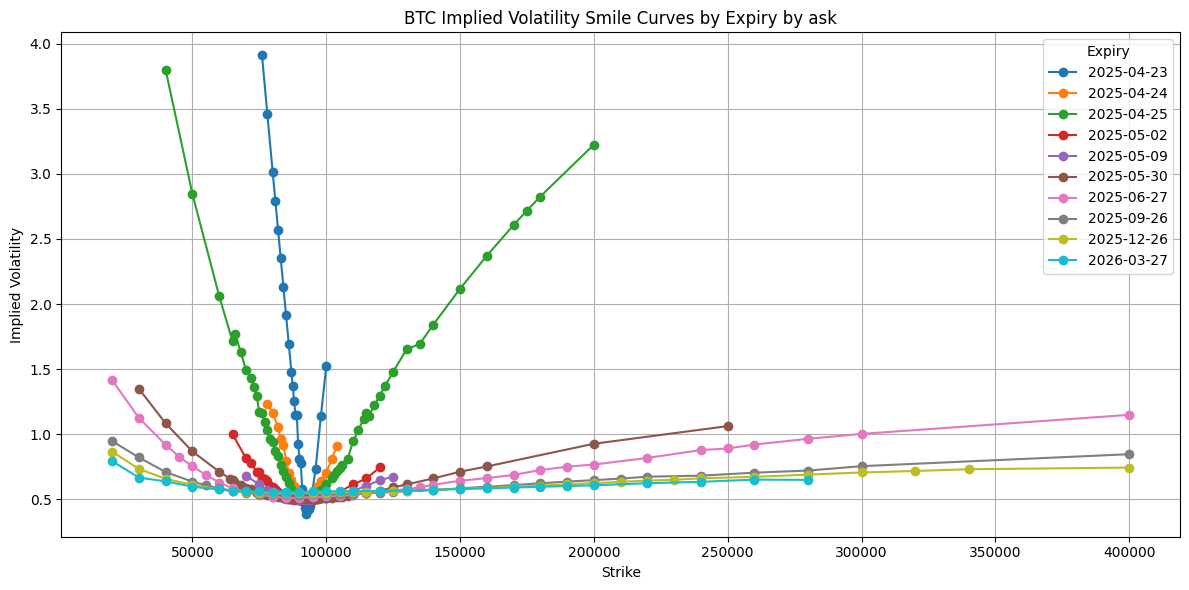

,strike,iv,expiry,mark_iv,bid_iv,ask_iv,type,mode
0,76000.0,3.910123,2025-04-23,130.97,0.00,390.79,put,ask
1,78000.0,3.456659,2025-04-23,130.97,0.00,345.46,put,ask
2,80000.0,3.010010,2025-04-23,130.82,0.00,300.81,put,ask
3,81000.0,2.788888,2025-04-23,126.92,0.00,278.71,put,ask
4,82000.0,2.568954,2025-04-23,115.38,0.00,256.72,put,ask
...,...,...,...,...,...,...,...,...
341,200000.0,0.607420,2026-03-27,60.21,59.55,60.74,call,ask
342,220000.0,0.624110,2026-03-27,61.58,60.84,62.41,call,ask
343,240000.0,0.634487,2026-03-27,62.79,61.92,63.45,call,ask
344,260000.0,0.651451,2026-03-27,64.15,63.15,65.15,call,ask


In [2]:
# price * S // otm_only
df_ask = plot_smile_curves(mode='ask', otm_only=True, cutoff_str='20261231')
df_ask

BTC-23APR25-91500-P {'strike': 91500.0, 'iv': 0.47884641037553544, 'expiry': '2025-04-23', 'mark_iv': 49.7, 'bid_iv': 47.86, 'ask_iv': 54.26, 'type': 'put'}
BTC-23APR25-92000-P {'strike': 92000.0, 'iv': 0.3552562646710254, 'expiry': '2025-04-23', 'mark_iv': 39.88, 'bid_iv': 35.5, 'ask_iv': 44.62, 'type': 'put'}
BTC-23APR25-92500-P {'strike': 92500.0, 'iv': 0.34281391148488854, 'expiry': '2025-04-23', 'mark_iv': 35.86, 'bid_iv': 34.26, 'ask_iv': 36.42, 'type': 'put'}
BTC-23APR25-93000-P {'strike': 93000.0, 'iv': 0.302719714183024, 'expiry': '2025-04-23', 'mark_iv': 35.66, 'bid_iv': 30.25, 'ask_iv': 39.47, 'type': 'put'}
BTC-23APR25-93500-C {'strike': 93500.0, 'iv': 0.3322459149393817, 'expiry': '2025-04-23', 'mark_iv': 38.46, 'bid_iv': 33.2, 'ask_iv': 37.55, 'type': 'call'}
BTC-23APR25-94000-C {'strike': 94000.0, 'iv': 0.37292643855171886, 'expiry': '2025-04-23', 'mark_iv': 41.85, 'bid_iv': 37.27, 'ask_iv': 44.33, 'type': 'call'}
BTC-24APR25-84000-P {'strike': 84000.0, 'iv': 0.763085568

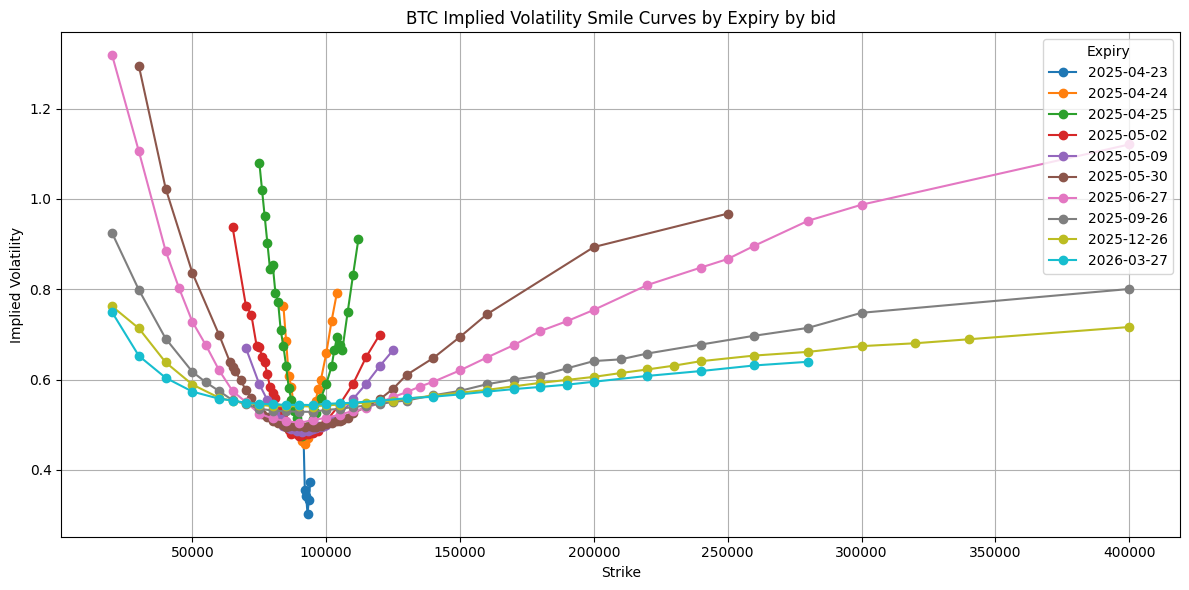

,strike,iv,expiry,mark_iv,bid_iv,ask_iv,type,mode
0,91500.0,0.478846,2025-04-23,49.70,47.86,54.26,put,bid
1,92000.0,0.355256,2025-04-23,39.88,35.50,44.62,put,bid
2,92500.0,0.342814,2025-04-23,35.86,34.26,36.42,put,bid
3,93000.0,0.302720,2025-04-23,35.66,30.25,39.47,put,bid
4,93500.0,0.332246,2025-04-23,38.46,33.20,37.55,call,bid
...,...,...,...,...,...,...,...,...
290,200000.0,0.595187,2026-03-27,60.17,59.52,60.71,call,bid
291,220000.0,0.608090,2026-03-27,61.59,60.81,62.38,call,bid
292,240000.0,0.618884,2026-03-27,62.78,61.89,63.42,call,bid
293,260000.0,0.631278,2026-03-27,64.14,63.13,65.12,call,bid


In [3]:
# price * S // otm_only
df_bid = plot_smile_curves(mode='bid', otm_only=True, cutoff_str='20261231')
df_bid

BTC-23APR25-91500-P {'strike': 91500.0, 'iv': 0.5310987232322821, 'expiry': '2025-04-23', 'mark_iv': 51.0, 'bid_iv': 49.44, 'ask_iv': 56.02, 'type': 'put'}
BTC-23APR25-92000-P {'strike': 92000.0, 'iv': 0.39954982288382784, 'expiry': '2025-04-23', 'mark_iv': 40.53, 'bid_iv': 36.97, 'ask_iv': 42.35, 'type': 'put'}
BTC-23APR25-92500-P {'strike': 92500.0, 'iv': 0.3370212900919664, 'expiry': '2025-04-23', 'mark_iv': 35.41, 'bid_iv': 30.99, 'ask_iv': 36.08, 'type': 'put'}
BTC-23APR25-93000-P {'strike': 93000.0, 'iv': 0.32789527787343636, 'expiry': '2025-04-23', 'mark_iv': 35.3, 'bid_iv': 30.0, 'ask_iv': 35.48, 'type': 'put'}
BTC-23APR25-93500-C {'strike': 93500.0, 'iv': 0.37803659856812577, 'expiry': '2025-04-23', 'mark_iv': 38.32, 'bid_iv': 33.46, 'ask_iv': 41.98, 'type': 'call'}
BTC-23APR25-94000-C {'strike': 94000.0, 'iv': 0.4038294190720723, 'expiry': '2025-04-23', 'mark_iv': 41.28, 'bid_iv': 36.63, 'ask_iv': 43.68, 'type': 'call'}
BTC-24APR25-84000-P {'strike': 84000.0, 'iv': 0.86339962

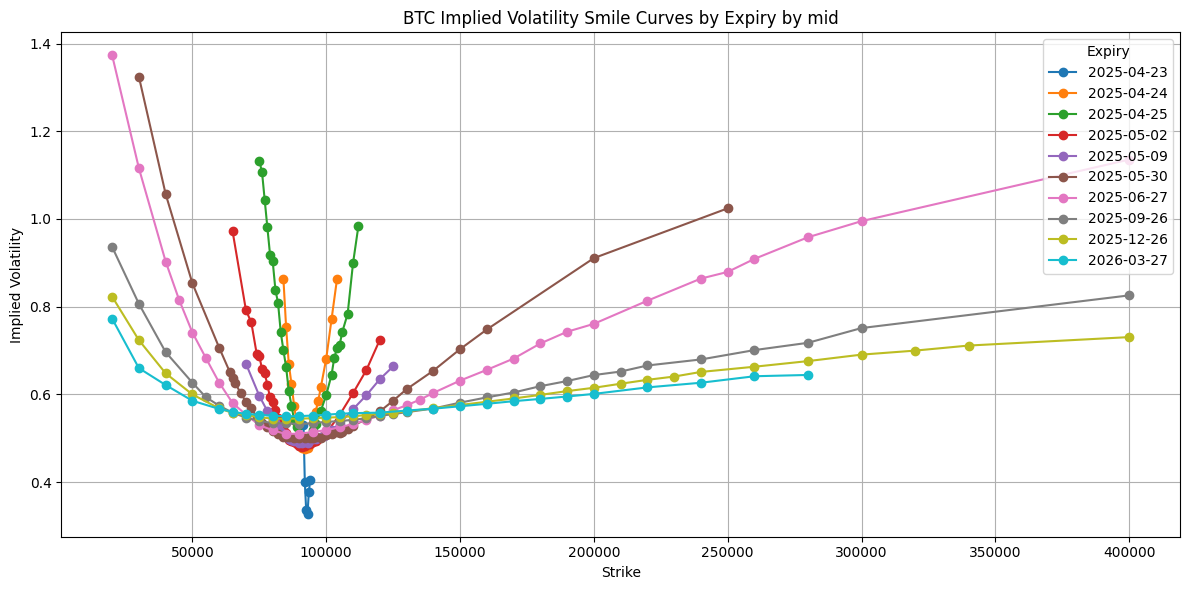

,strike,iv,expiry,mark_iv,bid_iv,ask_iv,type,mode
0,91500.0,0.531099,2025-04-23,51.00,49.44,56.02,put,mid
1,92000.0,0.399550,2025-04-23,40.53,36.97,42.35,put,mid
2,92500.0,0.337021,2025-04-23,35.41,30.99,36.08,put,mid
3,93000.0,0.327895,2025-04-23,35.30,30.00,35.48,put,mid
4,93500.0,0.378037,2025-04-23,38.32,33.46,41.98,call,mid
...,...,...,...,...,...,...,...,...
290,200000.0,0.601217,2026-03-27,60.14,59.52,60.71,call,mid
291,220000.0,0.616068,2026-03-27,61.59,60.81,62.38,call,mid
292,240000.0,0.626668,2026-03-27,62.77,61.89,63.42,call,mid
293,260000.0,0.641461,2026-03-27,64.13,63.13,65.12,call,mid


In [6]:
df_mid = plot_smile_curves(mode='mid', otm_only=True, cutoff_str='20261231')
df_mid

In [13]:
df_ask_ = df_ask[['strike', 'iv', 'expiry']].rename(columns={'iv':'iv_ask'})
df_mid_ = df_mid[['strike', 'iv', 'expiry']].rename(columns={'iv':'iv_mid'})
df_bid_ = df_bid[['strike', 'iv', 'expiry']].rename(columns={'iv':'iv_bid'})

df_merged = pd.merge(df_bid_, df_ask_, on=["strike", "expiry"], how="inner")
df_merged = pd.merge(df_merged, df_mid_, on=["strike", "expiry"], how="inner")[['strike', 'expiry', 'iv_bid', 'iv_mid', 'iv_ask']]

# melt로 long form 변환|
df_long = pd.melt(df_merged, id_vars=["strike", "expiry"], value_vars=["iv_ask", "iv_mid", "iv_bid"], var_name="iv_type", value_name="implied_volatility")

# Plotly로 인터랙티브 그래프 그리기
fig = px.line(df_long, x="strike", y="implied_volatility", color="expiry", line_dash="iv_type", markers=True,
    title="Interactive Implied Volatility Curve by Expiry and IV Type",
    labels={"strike": "Strike", "implied_volatility": "Implied Volatility"})

fig.update_layout(legend_title_text="Expiry / IV Type", hovermode="x unified")
fig.show()

In [ ]:
def plot_interactive_vol_surface(df):
    df = df.copy()
    df['expiry'] = pd.to_datetime(df['expiry'])
    df['expiry_days'] = (df['expiry'] - df['expiry'].min()).dt.days

    fig = go.Figure()

    # 각 만기별로 IV Bid와 IV Ask 트레이스 추가
    for expiry in df['expiry'].unique():
        df_expiry = df[df['expiry'] == expiry]
        expiry_str = expiry.strftime('%Y-%m-%d')

        # IV Bid 트레이스
        fig.add_trace(go.Scatter3d(
            x=df_expiry['strike'],
            y=df_expiry['expiry_days'],
            z=df_expiry['iv_bid'],
            mode='markers',
            marker=dict(size=4, color='blue', line=dict(color='black', width=1)),
            name=f'IV Bid ({expiry_str})',
            legendgroup=f'IV Bid ({expiry_str})',
            showlegend=True
        ))

        # IV Ask 트레이스
        fig.add_trace(go.Scatter3d(
            x=df_expiry['strike'],
            y=df_expiry['expiry_days'],
            z=df_expiry['iv_ask'],
            mode='markers',
            marker=dict(size=4, color='red', line=dict(color='black', width=1)),
            name=f'IV Ask ({expiry_str})',
            legendgroup=f'IV Ask ({expiry_str})',
            showlegend=True
        ))

    fig.update_layout(
        title='Interactive Volatility Surface (Bid & Ask by Expiry)',
        width=1200,
        height=1200,
        scene=dict(
            xaxis_title='Strike',
            yaxis_title='Days to Expiry',
            zaxis_title='Implied Volatility'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

plot_interactive_vol_surface(df_merged)

In [ ]:
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

def plot_smooth_vol_surface(df, vol_type='iv_bid', method='cubic', sigma=1.0):
    """
    df: DataFrame with columns ['strike', 'expiry', 'iv_bid', 'iv_ask']
    vol_type: 'iv_bid' or 'iv_ask'
    method: interpolation method - 'linear', 'cubic', or 'nearest'
    sigma: standard deviation for Gaussian filter
    """
    df = df.copy()
    df['expiry'] = pd.to_datetime(df['expiry'])
    df['expiry_days'] = (df['expiry'] - df['expiry'].min()).dt.days

    # Prepare grid
    strike_vals = np.linspace(df['strike'].min(), df['strike'].max(), 100)
    expiry_vals = np.linspace(df['expiry_days'].min(), df['expiry_days'].max(), 100)
    strike_grid, expiry_grid = np.meshgrid(strike_vals, expiry_vals)

    # Interpolate IV data onto grid
    points = df[['strike', 'expiry_days']].values
    values = df[vol_type].values
    iv_grid = griddata(points, values, (strike_grid, expiry_grid), method=method)

    # Apply Gaussian filter for smoothing
    iv_grid_smooth = gaussian_filter(iv_grid, sigma=sigma)

    # Plot
    fig = go.Figure(data=[go.Surface(
        x=strike_grid,
        y=expiry_grid,
        z=iv_grid_smooth,
        colorscale='Viridis',
        name=vol_type.upper()
    )])

    fig.update_layout(
        title=f'Smoothed Volatility Surface ({vol_type.upper()})',
        width=1200,
        height=800,
        scene=dict(
            xaxis_title='Strike',
            yaxis_title='Days to Expiry',
            zaxis_title='Implied Volatility'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()

# methood : 'linear', 'cubic', 'nearest' 중에서 선택할 수 있습니다. ('cubic'은 더 부드러운 결과를 제공)
# gaussian_filter의 sigma 값은 필터의 표준 편차를 의미하며, 값이 클수록 더 부드러운 결과를 얻을 수 있습니다.
plot_smooth_vol_surface(df_merged, vol_type='iv_ask', method='cubic', sigma=5.0)

In [ ]:
# 버터플라이 차익 탐색 함수
def find_butterfly_arbitrage2(df, threshold=0.01):
  ideas = []

  for expiry in df['expiry'].unique():
    df_e = df[df['expiry'] == expiry].sort_values('strike').reset_index(drop=True)

    for i in range(1, len(df_e)-1):
        K1, K2, K3 = df_e.loc[i-1, 'strike'], df_e.loc[i, 'strike'], df_e.loc[i+1, 'strike']
        iv1 = (df_e.loc[i-1, 'iv_bid'] + df_e.loc[i-1, 'iv_ask']) / 2
        iv2 = (df_e.loc[i, 'iv_bid'] + df_e.loc[i, 'iv_ask']) / 2
        iv3 = (df_e.loc[i+1, 'iv_bid'] + df_e.loc[i+1, 'iv_ask']) / 2

        side_avg = (iv1 + iv3) / 2

        # Short Butterfly (중심 IV가 튀었을 때 → 매도)
        if iv2 - side_avg > threshold:
            ideas.append({
                "type": "Butterfly Short",
                "K1": K1, "K2": K2, "K3": K3,
                "iv_center": iv2,
                "iv_side_avg": side_avg,
                "expiry": expiry
            })

        # Long Butterfly (중심 IV가 꺼졌을 때 → 매수)
        if side_avg - iv2 > threshold:
            ideas.append({
                "type": "Butterfly Long",
                "K1": K1, "K2": K2, "K3": K3,
                "iv_center": iv2,
                "iv_side_avg": side_avg,
                "expiry": expiry
            })

  return pd.DataFrame(ideas)

In [ ]:
find_butterfly_arbitrage2(df_merged, threshold=0.025)

,type,K1,K2,K3,iv_center,iv_side_avg,expiry
0,Butterfly Long,91000.0,92000.0,94000.0,0.478469,0.504872,2025-04-23
1,Butterfly Long,78000.0,80000.0,82000.0,0.640257,0.666681,2025-04-24
2,Butterfly Long,96000.0,98000.0,100000.0,0.615942,0.644239,2025-04-24
3,Butterfly Long,70000.0,72000.0,73000.0,0.949760,0.996201,2025-04-25
4,Butterfly Short,100000.0,102000.0,103000.0,0.705152,0.675707,2025-04-25
5,Butterfly Long,65000.0,70000.0,72000.0,0.691007,0.727982,2025-05-02
6,Butterfly Long,30000.0,40000.0,50000.0,1.009702,1.037206,2025-05-30
7,Butterfly Long,50000.0,60000.0,64000.0,0.658770,0.713445,2025-05-30
8,Butterfly Long,150000.0,160000.0,200000.0,0.769705,0.816026,2025-05-30
9,Butterfly Long,20000.0,30000.0,40000.0,1.061240,1.091328,2025-06-27


In [ ]:
# 버터플라이 차익 탐색 함수
def find_butterfly_arbitrage(df, threshold=0.01):
  ideas = []

  for expiry in df['expiry'].unique():
    df_e = df[df['expiry'] == expiry].sort_values('strike').reset_index(drop=True)

    for i in range(1, len(df_e)-1):
        K1, K2, K3 = df_e.loc[i-1, 'strike'], df_e.loc[i, 'strike'], df_e.loc[i+1, 'strike']
        iv1 = (df_e.loc[i-1, 'iv_bid'] + df_e.loc[i-1, 'iv_ask']) / 2
        iv2 = (df_e.loc[i, 'iv_bid'] + df_e.loc[i, 'iv_ask']) / 2
        iv3 = (df_e.loc[i+1, 'iv_bid'] + df_e.loc[i+1, 'iv_ask']) / 2

        side_avg = (iv1 + iv3) / 2

        # Short Butterfly (중심 IV가 튀었을 때 → 매도)
        if iv2 - side_avg > threshold:
            ideas.append({
                "type": "Butterfly Short",
                "K1": K1, "K2": K2, "K3": K3,
                "iv_center": iv2,
                "iv_side_avg": side_avg,
                "expiry": expiry
            })

        # Long Butterfly (중심 IV가 꺼졌을 때 → 매수)
        if side_avg - iv2 > threshold:
            ideas.append({
                "type": "Butterfly Long",
                "K1": K1, "K2": K2, "K3": K3,
                "iv_center": iv2,
                "iv_side_avg": side_avg,
                "expiry": expiry
            })

  return pd.DataFrame(ideas)

# 버터플라이 시각화 함수
def plot_butterfly_opportunities(df_butterfly):
    for _, row in df_butterfly.iterrows():
        strikes = [row['K1'], row['K2'], row['K3']]
        ivs = [row['iv_side_avg'], row['iv_center'], row['iv_side_avg']]
        plt.plot(strikes, ivs, marker='o', label=f"Expiry: {row['expiry']}")

    plt.title("Butterfly Arbitrage Opportunities")
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

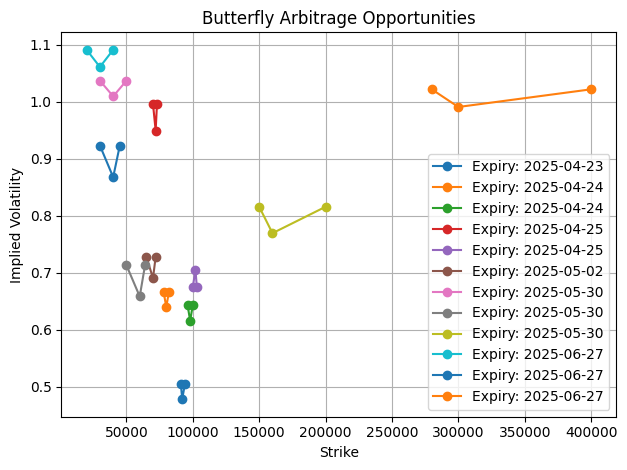

,type,K1,K2,K3,iv_center,iv_side_avg,expiry
0,Butterfly Long,91000.0,92000.0,94000.0,0.478469,0.504872,2025-04-23
1,Butterfly Long,78000.0,80000.0,82000.0,0.640257,0.666681,2025-04-24
2,Butterfly Long,96000.0,98000.0,100000.0,0.615942,0.644239,2025-04-24
3,Butterfly Long,70000.0,72000.0,73000.0,0.949760,0.996201,2025-04-25
4,Butterfly Short,100000.0,102000.0,103000.0,0.705152,0.675707,2025-04-25
5,Butterfly Long,65000.0,70000.0,72000.0,0.691007,0.727982,2025-05-02
6,Butterfly Long,30000.0,40000.0,50000.0,1.009702,1.037206,2025-05-30
7,Butterfly Long,50000.0,60000.0,64000.0,0.658770,0.713445,2025-05-30
8,Butterfly Long,150000.0,160000.0,200000.0,0.769705,0.816026,2025-05-30
9,Butterfly Long,20000.0,30000.0,40000.0,1.061240,1.091328,2025-06-27


In [ ]:
df_butterfly = find_butterfly_arbitrage(df_merged, threshold=0.025)
plot_butterfly_opportunities(df_butterfly)
df_butterfly

In [ ]:
# 캘린더 차익 탐색 함수
def find_calendar_arbitrage(df, threshold=0.03):
    grouped = df.groupby('strike')
    ideas = []

    for strike, group in grouped:
        if len(group) < 2:
            continue
        group = group.sort_values('expiry')
        for i in range(len(group)-1):
            near = group.iloc[i]
            far = group.iloc[i+1]

            iv_near = (near['iv_bid'] + near['iv_ask']) / 2
            iv_far = (far['iv_bid'] + far['iv_ask']) / 2

            if abs(iv_far - iv_near) > threshold:
                ideas.append({
                    "type": "Calendar Spread",
                    "strike": strike,
                    "near_expiry": near['expiry'],
                    "far_expiry": far['expiry'],
                    "iv_near": iv_near,
                    "iv_far": iv_far,
                    "direction": "Long Calendar" if iv_far > iv_near else "Short Calendar"
                })
    return pd.DataFrame(ideas)

def find_calendar_butterfly(df, threshold=0.03):
  ideas = []
  grouped = df.groupby('strike')

  for strike, group in grouped:
      if len(group) < 3:
          continue

      group = group.sort_values('expiry').reset_index(drop=True)

      for i in range(len(group)-2):
          T1 = group.iloc[i]
          T2 = group.iloc[i+1]
          T3 = group.iloc[i+2]

          iv1 = (T1['iv_bid'] + T1['iv_ask']) / 2
          iv2 = (T2['iv_bid'] + T2['iv_ask']) / 2
          iv3 = (T3['iv_bid'] + T3['iv_ask']) / 2

          side_avg = (iv1 + iv3) / 2
          diff = iv2 - side_avg

          if abs(diff) > threshold:
              direction = "Short Calendar Butterfly" if diff > 0 else "Long Calendar Butterfly"
              ideas.append({
                  'type': 'Calendar Butterfly',
                  'direction': direction,
                  'strike': strike,
                  'T1': T1['expiry'],
                  'T2': T2['expiry'],
                  'T3': T3['expiry'],
                  'iv_T1': iv1,
                  'iv_T2': iv2,
                  'iv_T3': iv3,
                  'center_deviation' : diff
              })

  return pd.DataFrame(ideas)

# 캘린더 차익 시각화 함수
def plot_calendar_opportunities(df_calendar):
    plt.figure(figsize=(10, 6))
    for _, row in df_calendar.iterrows():
        x = pd.to_datetime([row['near_expiry'], row['far_expiry']])
        y = [row['iv_near'], row['iv_far']]
        plt.plot(x, y, marker='o', label=f"Strike {row['strike']} ({row['direction']})")

    plt.title("Calendar Arbitrage Across Expiries")
    plt.xlabel("Expiry")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 캘린더 버터플라이 시각화 함수
def plot_calendar_butterfly_opportunities(df_calendar_butterfly):
    plt.figure(figsize=(10, 6))
    for _, row in df_calendar_butterfly.iterrows():
        expiries = pd.to_datetime([row['T1'], row['T2'], row['T3']])
        ivs = [row['iv_T1'], row['iv_T2'], row['iv_T3']]
        plt.plot(expiries, ivs, marker='o', label=f"Strike: {row['strike']} ({row['direction']})")

    plt.title("Calendar Butterfly Opportunities")
    plt.xlabel("Expiry")
    plt.ylabel("Implied Volatility")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
# df_cal = find_calendar_arbitrage(df_merged, threshold=0.25)
# plot_calendar_opportunities(df_cal)
# df_cal

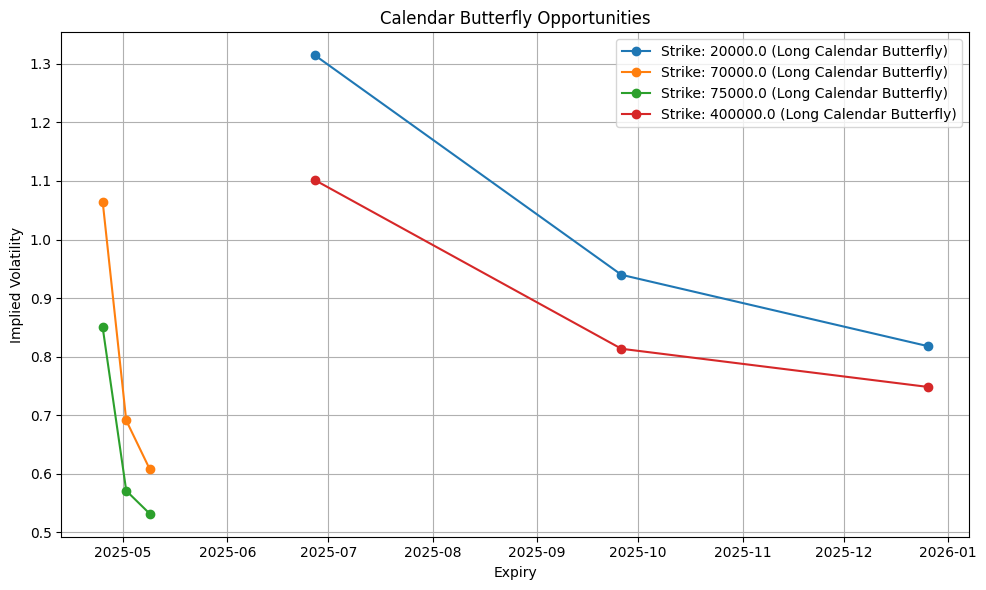

,type,direction,strike,T1,T2,T3,iv_T1,iv_T2,iv_T3,center_deviation
0,Calendar Butterfly,Long Calendar Butterfly,20000.0,2025-06-27,2025-09-26,2025-12-26,1.314657,0.939769,0.817928,-0.126523
1,Calendar Butterfly,Long Calendar Butterfly,70000.0,2025-04-25,2025-05-02,2025-05-09,1.064777,0.691007,0.607577,-0.145170
2,Calendar Butterfly,Long Calendar Butterfly,75000.0,2025-04-25,2025-05-02,2025-05-09,0.849994,0.571010,0.531657,-0.119815
3,Calendar Butterfly,Long Calendar Butterfly,400000.0,2025-06-27,2025-09-26,2025-12-26,1.101506,0.813461,0.748298,-0.111441


In [ ]:
df_calendar_butterfly = find_calendar_butterfly(df_merged, threshold=0.11)
plot_calendar_butterfly_opportunities(df_calendar_butterfly)
df_calendar_butterfly

In [ ]:
from datetime import datetime, timezone
from pysabr import Hagan2002LognormalSABR

def plot_sabr_vol_curve(df, expiry_date_str, beta=0.5):
    """
    지정된 만기일에 대한 SABR 변동성 곡선을 시각화합니다.
    """
    # 해당 만기의 데이터 필터링
    df_expiry = df[df['expiry'] == expiry_date_str].copy()

    # 'iv_mid' 컬럼이 없는 경우 생성
    if 'iv_mid' not in df_expiry.columns:
        df_expiry['iv_mid'] = (df_expiry['iv_bid'] + df_expiry['iv_ask']) / 2

    strikes = df_expiry['strike'].values
    vols = df_expiry['iv_mid'].values

    # 현재 BTC 선물 가격 가져오기
    f = get_btc_futures_last_price()
    if f is None:
        print("현재 BTC 선물 가격을 가져올 수 없습니다.")
        return

    # Deribit 옵션 만기 시간은 08:00 UTC
    try:
        expiry_datetime = datetime.strptime(expiry_date_str, '%Y-%m-%d').replace(hour=8, minute=0, second=0, tzinfo=timezone.utc)
        now = datetime.utcnow().replace(tzinfo=timezone.utc)
        t = (expiry_datetime - now).total_seconds() / (365 * 24 * 60 * 60)
        if t <= 0:
            print("만기일이 이미 지났습니다.")
            return
    except Exception as e:
        print(f"만기 시간 계산 중 오류 발생: {e}")
        return

    # SABR 모델 초기화 및 피팅
    sabr_model = Hagan2002LognormalSABR(f=f, t=t, beta=beta)
    try:
        alpha, rho, volvol = sabr_model.fit(strikes, vols)
    except Exception as e:
        print(f"SABR 모델 피팅 중 오류 발생: {e}")
        return

    # 피팅된 변동성 계산
    fitted_vols = [sabr_model.lognormal_vol(k) for k in strikes]

    # 결과 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, vols, 'o', label='Market IV')
    plt.plot(strikes, fitted_vols, '-', label='SABR Fit')
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.title(f'SABR Volatility Curve for Expiry {expiry_date_str}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_sabr_vol_curve(df_merged, df_merged['expiry'].values[-1])

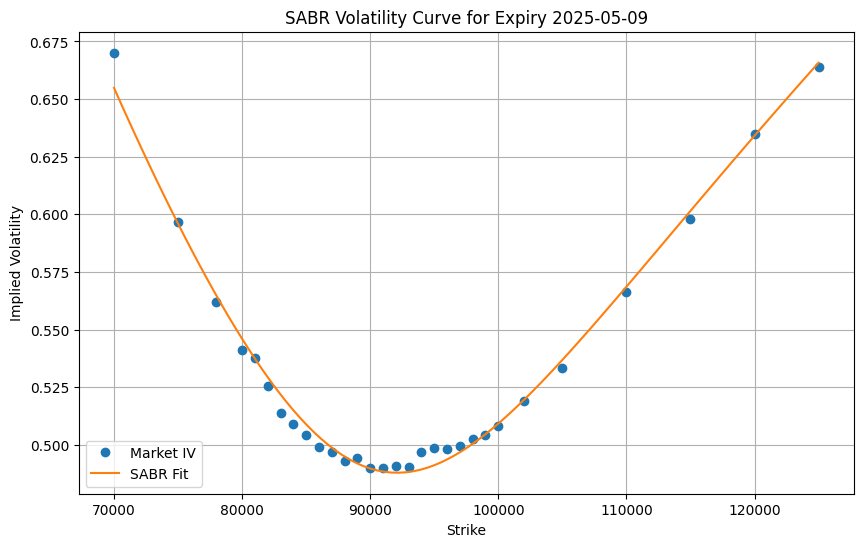

In [47]:
from pysabr import Hagan2002LognormalSABR
from pysabr import hagan_2002_lognormal_sabr as hagan2002

def plot_sabr_vol_curve(df, expiry_date_str, beta=0.5):
    """
    지정된 만기일에 대한 SABR 변동성 곡선을 시각화합니다.
    """
    # 해당 만기의 데이터 필터링
    df_expiry = df[df['expiry'] == expiry_date_str].copy()

    # 'iv_mid' 컬럼이 없는 경우 생성
    if 'iv_mid' not in df_expiry.columns:
        df_expiry['iv_mid'] = (df_expiry['iv_bid'] + df_expiry['iv_ask']) / 2

    strikes = df_expiry['strike'].values
    vols = df_expiry['iv_mid'].values

    # 현재 BTC 선물 가격 가져오기
    f = get_btc_futures_last_price()
    if f is None:
        print("현재 BTC 선물 가격을 가져올 수 없습니다.")
        return

    # Deribit 옵션 만기 시간은 08:00 UTC
    try:
        expiry_datetime = datetime.strptime(expiry_date_str, '%Y-%m-%d').replace(hour=8, minute=0, second=0, tzinfo=timezone.utc)
        now = datetime.utcnow().replace(tzinfo=timezone.utc)
        t = (expiry_datetime - now).total_seconds() / (365 * 24 * 60 * 60)
        if t <= 0:
            print("만기일이 이미 지났습니다.")
            return
    except Exception as e:
        print(f"만기 시간 계산 중 오류 발생: {e}")
        return

    # SABR 모델 초기화 및 피팅
    sabr_model = Hagan2002LognormalSABR(f=f, t=t, beta=beta)
    try:
        alpha, rho, volvol = sabr_model.fit(strikes, vols)
    except Exception as e:
        print(f"SABR 모델 피팅 중 오류 발생: {e}")
        return

    # 보간을 위한 스트라이크 범위 생성
    k_min, k_max = strikes.min(), strikes.max()
    k_interp = np.linspace(k_min, k_max, 100)

    # 피팅된 변동성 계산
    fitted_vols = [hagan2002.lognormal_vol(k, f, t, alpha, beta, rho, volvol) * 100 for k in k_interp]

    # 결과 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(strikes, vols, 'o', label='Market IV')
    plt.plot(k_interp, fitted_vols, '-', label='SABR Fit')
    plt.xlabel('Strike')
    plt.ylabel('Implied Volatility')
    plt.title(f'SABR Volatility Curve for Expiry {expiry_date_str}')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_sabr_vol_curve(df_merged, df_merged['expiry'].unique()[4])

In [9]:
# Deribit에서 옵션 리스트 가져오기
def get_option_instruments(currency="BTC", kind="option", expired=False):
    url = "https://www.deribit.com/api/v2/public/get_instruments"
    params = {
        "currency": currency,
        "kind": kind,
        "expired": str(expired).lower()  # API는 'true' or 'false' string을 요구함
    }

    response = requests.get(url, params=params)
    data = response.json()

    if 'error' in data:
        print(f"API Error: {data['error']['message']}")
        return []

    instruments = data.get("result", [])
    return instruments

In [15]:
call = get_option_instruments()

In [18]:
call[1]

{'price_index': 'btc_usd',
 'rfq': False,
 'kind': 'option',
 'instrument_name': 'BTC-24APR25-78000-P',
 'maker_commission': 0.0003,
 'taker_commission': 0.0003,
 'instrument_type': 'reversed',
 'expiration_timestamp': 1745481600000,
 'creation_timestamp': 1745222408000,
 'is_active': True,
 'tick_size': 0.0001,
 'contract_size': 1.0,
 'strike': 78000.0,
 'base_currency': 'BTC',
 'instrument_id': 456209,
 'settlement_period': 'day',
 'min_trade_amount': 0.1,
 'option_type': 'put',
 'block_trade_commission': 0.0003,
 'block_trade_min_trade_amount': 25,
 'block_trade_tick_size': 0.0001,
 'settlement_currency': 'BTC',
 'counter_currency': 'USD',
 'quote_currency': 'BTC',
 'tick_size_steps': [{'tick_size': 0.0005, 'above_price': 0.005}]}

In [ ]:
import requests

import pandas as pd
pd.set_option('display.width', 0)  # 무제한 너비
pd.set_option('display.max_columns', None)  # 모든 컬럼 출력
pd.set_option('display.expand_frame_repr', False)  # 줄바꿈 없이 한 줄로 출력

from concurrent.futures import ThreadPoolExecutor, as_completed

# Deribit에서 BTC 콜 옵션 데이터 불러오기
def get_deribit_options(option_type='call'):
    res = get_option_instruments()

    # 콜 옵션만 추출
    target_option = [x for x in res if x["option_type"] == option_type]
    return target_option

# # 각 옵션의 호가 가져오기
# def get_order_book(instrument_name):
#     url = "https://www.deribit.com/api/v2/public/get_order_book"
#     params = {"instrument_name": instrument_name}
#     res = requests.get(url, params=params).json()
#     return res["result"]

# 병렬 Order Book 요청
def fetch_order_books_parallel(option_list, max_workers=10):
    results = []

    def fetch(option):
        try:
            url = "https://www.deribit.com/api/v2/public/get_order_book"
            params = {"instrument_name": option["instrument_name"]}
            res = requests.get(url, params=params, timeout=3).json()
            ob = res["result"]
            if ob["best_ask_price"] and ob["best_bid_price"]:
                return {
                    "strike": option["strike"],
                    "instrument": option["instrument_name"],
                    "bid": ob["best_bid_price"],
                    "ask": ob["best_ask_price"]
                }
        except Exception as e:
            #print(f"오류 발생: {option['instrument_name']} - {e}")
          return None

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {executor.submit(fetch, opt): opt for opt in option_list}
        for f in as_completed(futures):
            result = f.result()
            if result:
                results.append(result)

    return pd.DataFrame(results)

def detect_convexity_arbitrage(df, option_type):
    df_sorted = df.sort_values("strike")
    violations = []

    for i in range(1, len(df_sorted) - 1):
        K1 = df_sorted.iloc[i - 1]
        K2 = df_sorted.iloc[i]
        K3 = df_sorted.iloc[i + 1]

        if any([
            K1["ask"] in [None, 0],
            K2["bid"] in [None, 0],
            K3["ask"] in [None, 0]
        ]):
            continue

        # 수수료 계산 (Taker: 0.05% of premium, capped at 12.5%)
        fee_K1 = min(0.0005 * K1["ask"], 0.125 * K1["ask"])
        fee_K2 = min(0.0005 * K2["bid"], 0.125 * K2["bid"]) * 2
        fee_K3 = min(0.0005 * K3["ask"], 0.125 * K3["ask"])
        total_fee = fee_K1 + fee_K2 + fee_K3
        total_fee = 0

        K1_strike = K1["strike"]
        K2_strike = K2["strike"]
        K3_strike = K3["strike"]

        if K3_strike == K1_strike:
            continue  # 분모 0 방지

        w_lambda = (K3_strike - K2_strike) / (K3_strike - K1_strike)
        avg_outer_ask = w_lambda * K1["ask"] + (1 - w_lambda) * K3["ask"]
        mid_bid = K2["bid"]

        net_profit = mid_bid - avg_outer_ask - total_fee
        if net_profit > 0:
            violations.append({
                "option_type": option_type,
                "K1": K1["strike"],
                "K2": K2["strike"],
                "K3": K3["strike"],
                "ask_K1": K1["ask"],
                "bid_K2": mid_bid,
                "ask_K3": K3["ask"],
                "avg(K1,K3)_ask": avg_outer_ask,
                "fee_total": round(total_fee, 8),
                "net_profit_after_fee": round(net_profit, 8)
            })

    return pd.DataFrame(violations)

def run_continuous_check(interval_sec=300):
    # 🔁 get_deribit_options() 딱 1번씩만 호출
    call_options = get_deribit_options('call')
    put_options = get_deribit_options('put')

    while True:
        print(f"\n⏱️ 실행 시간: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")

        call_violations = analyze_recent_expiries_from_data(call_options, 'call', 5)
        put_violations = analyze_recent_expiries_from_data(put_options, 'put', 5)

        if call_violations.empty and put_violations.empty:
            print("✅ 현재 Convexity 위반 없음")
        else:
            print("\n⚠️ Convexity 위반 포착:")
            if not call_violations.empty:
                print("📈 Call 옵션 위반:")
                print(call_violations)
            if not put_violations.empty:
                print("📉 Put 옵션 위반:")
                print(put_violations)

        # print(f"\n⏳ {interval_sec}초 후 다시 실행...\n")
        time.sleep(interval_sec)

# 옵션 데이터를 인자로 받도록 수정
def analyze_recent_expiries_from_data(options, option_type='call', n_expiry=5):
    if not options:
        return pd.DataFrame()

    expiries = sorted(set(x["expiration_timestamp"] for x in options))[:n_expiry]
    all_violations = []

    for expiry in expiries:
        filtered = [x for x in options if x["expiration_timestamp"] == expiry]

        df = fetch_order_books_parallel(filtered, max_workers=20)

        if df.empty:
            continue

        violations = detect_convexity_arbitrage(df, option_type)
        if not violations.empty:
            violations["expiry"] = datetime.utcfromtimestamp(expiry / 1000).strftime('%Y-%m-%d')
            all_violations.append(violations)

    return pd.concat(all_violations, ignore_index=True) if all_violations else pd.DataFrame()

# ▶️ 실행 (interval_sec 주기)
run_continuous_check(interval_sec=0)

In [82]:
import requests
import asyncio
import aiohttp
import pandas as pd
import time
from datetime import datetime
import nest_asyncio

nest_asyncio.apply()  # 주피터 환경에서 asyncio 중첩 허용

pd.set_option('display.width', 0)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

def get_deribit_options(option_type='call'):
    res = get_option_instruments()
    return [x for x in res if x["option_type"] == option_type]

# Async Order Book 요청
async def fetch_order_book(session, option):
    url = "https://www.deribit.com/api/v2/public/get_order_book"
    params = {"instrument_name": option["instrument_name"]}
    try:
        async with session.get(url, params=params, timeout=5) as resp:
            data = await resp.json()
            ob = data.get("result", {})
            if ob.get("best_ask_price") and ob.get("best_bid_price"):
                return {
                    "strike": option["strike"],
                    "instrument": option["instrument_name"],
                    "bid": ob["best_bid_price"],
                    "ask": ob["best_ask_price"]
                }
    except:
        return None

async def fetch_order_books_for_expiry(session, option_list):
    tasks = [fetch_order_book(session, opt) for opt in option_list]
    results = await asyncio.gather(*tasks)
    return [r for r in results if r]

async def analyze_recent_expiries_async(options, option_type='call', n_expiry=5):
    if not options:
        return pd.DataFrame()

    expiries = sorted(set(x["expiration_timestamp"] for x in options))[:n_expiry]
    expiry_groups = [[x for x in options if x["expiration_timestamp"] == expiry] for expiry in expiries]

    connector = aiohttp.TCPConnector(limit=100)
    timeout = aiohttp.ClientTimeout(total=10)

    all_violations = []
    async with aiohttp.ClientSession(connector=connector, timeout=timeout) as session:
        fetch_tasks = [fetch_order_books_for_expiry(session, group) for group in expiry_groups]
        all_results = await asyncio.gather(*fetch_tasks)

        for i, result in enumerate(all_results):
            df = pd.DataFrame(result)
            if df.empty:
                continue
            violations = detect_convexity_arbitrage(df, option_type)
            if not violations.empty:
                expiry = datetime.utcfromtimestamp(expiries[i] / 1000).strftime('%Y-%m-%d')
                violations["expiry"] = expiry
                all_violations.append(violations)

    return pd.concat(all_violations, ignore_index=True) if all_violations else pd.DataFrame()

def detect_convexity_arbitrage(df, option_type):
    df_sorted = df.sort_values("strike")
    violations = []

    for i in range(1, len(df_sorted) - 1):
        K1, K2, K3 = df_sorted.iloc[i - 1], df_sorted.iloc[i], df_sorted.iloc[i + 1]
        if any([
            K1["ask"] in [None, 0],
            K2["bid"] in [None, 0],
            K3["ask"] in [None, 0]
        ]):
            continue

        fee_K1 = min(0.0005 * K1["ask"], 0.125 * K1["ask"])
        fee_K2 = min(0.0005 * K2["bid"], 0.125 * K2["bid"]) * 2
        fee_K3 = min(0.0005 * K3["ask"], 0.125 * K3["ask"])
        total_fee = fee_K1 + fee_K2 + fee_K3

        K1_strike, K2_strike, K3_strike = K1["strike"], K2["strike"], K3["strike"]
        if K3_strike == K1_strike:
            continue

        w_lambda = (K3_strike - K2_strike) / (K3_strike - K1_strike)
        avg_outer_ask = w_lambda * K1["ask"] + (1 - w_lambda) * K3["ask"]
        mid_bid = K2["bid"]

        net_profit = mid_bid - avg_outer_ask - total_fee
        if net_profit > 0:
            violations.append({
                "option_type": option_type,
                "K1": K1_strike,
                "K2": K2_strike,
                "K3": K3_strike,
                "ask_K1": K1["ask"],
                "bid_K2": mid_bid,
                "ask_K3": K3["ask"],
                "avg(K1,K3)_ask": avg_outer_ask,
                "fee_total": round(total_fee, 8),
                "net_profit_after_fee": round(net_profit, 8)
            })

    return pd.DataFrame(violations)

def run_continuous_check(interval_sec=300):
    call_options = get_deribit_options('call')
    put_options = get_deribit_options('put')

    while True:
        print(f"\n⏱️ 실행 시간: {datetime.utcnow().strftime('%Y-%m-%d %H:%M:%S')} UTC")

        call_violations = asyncio.get_event_loop().run_until_complete(
            analyze_recent_expiries_async(call_options, 'call', 5)
        )
        put_violations = asyncio.get_event_loop().run_until_complete(
            analyze_recent_expiries_async(put_options, 'put', 5)
        )

        if call_violations.empty and put_violations.empty:
            print("✅ 현재 Convexity 위반 없음")
        else:
            print("\n⚠️ Convexity 위반 포착:")
            if not call_violations.empty:
                print("📈 Call 옵션 위반:")
                print(call_violations)
            if not put_violations.empty:
                print("📉 Put 옵션 위반:")
                print(put_violations)

        time.sleep(interval_sec)

# ▶️ 실행
run_continuous_check(interval_sec=0)


⏱️ 실행 시간: 2025-04-23 10:58:10 UTC
✅ 현재 Convexity 위반 없음

⏱️ 실행 시간: 2025-04-23 10:58:11 UTC
✅ 현재 Convexity 위반 없음

⏱️ 실행 시간: 2025-04-23 10:58:13 UTC
✅ 현재 Convexity 위반 없음

⏱️ 실행 시간: 2025-04-23 10:58:14 UTC
✅ 현재 Convexity 위반 없음

⏱️ 실행 시간: 2025-04-23 10:58:15 UTC
✅ 현재 Convexity 위반 없음

⏱️ 실행 시간: 2025-04-23 10:58:17 UTC
✅ 현재 Convexity 위반 없음

⏱️ 실행 시간: 2025-04-23 10:58:18 UTC
✅ 현재 Convexity 위반 없음

⏱️ 실행 시간: 2025-04-23 10:58:20 UTC
✅ 현재 Convexity 위반 없음

⏱️ 실행 시간: 2025-04-23 10:58:21 UTC


KeyboardInterrupt: 

In [ ]:
get_iv_for_option(inst_name)

{'timestamp': 1745227517223, 'state': 'open', 'stats': {'high': None, 'low': None, 'price_change': None, 'volume': 0.0, 'volume_usd': 0.0}, 'greeks': {'delta': 0.99991, 'gamma': 0.0, 'vega': 0.01606, 'theta': -0.5964, 'rho': 1.95908}, 'change_id': 97992839864, 'index_price': 87448.23, 'instrument_name': 'BTC-22APR25-76000-C', 'bids': [[0.0995, 10.3]], 'asks': [[0.1605, 10.3]], 'last_price': None, 'settlement_price': 0.13092624, 'min_price': 0.0995, 'max_price': 0.1605, 'open_interest': 0.0, 'mark_price': 0.131, 'best_ask_price': 0.1605, 'best_bid_price': 0.0995, 'interest_rate': 0.0, 'mark_iv': 74.25, 'bid_iv': 0.0, 'ask_iv': 414.29, 'underlying_price': 87456.8408, 'underlying_index': 'SYN.BTC-22APR25', 'estimated_delivery_price': 87448.23, 'best_ask_amount': 10.3, 'best_bid_amount': 10.3}
